Regularization:

- in OLS (MNK), we are searching for parameters B, that minimize the sum of squared errors (SSE), i.e. the squared differences between the observed values and the predicted values;
- in addition, the regularization modifies this objective by adding a penalty term to the loss function to discourage large parameter values. It encourages parameters to be small (close to zero), helping to prevent overfitting;
- this increases bias but reduces variance, improving generalization and reducing the risk of overfitting;

Motivation: We want to minimize prediction error (SSE), but also prevent overfitting by keeping the model coefficients small. Regularization achieves this by balancing two goals:

- Good fit to the data (low SSE),
- Model simplicity (small coefficients).

I will not use pure Ridge regression, because earlier manual variable selection indicated that only a few predictors are significant, while the remaining coefficients are either zero or close to zero. In such cases, Lasso is more appropriate, as it performs variable selection by shrinking some coefficients exactly to zero.

In [10]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation tools
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

import pickle


In [11]:
# Load pre-encoded training and test datasets (categorical variables already encoded)

with open("outputs/df_companies_train_test_encoded_CLEANED.pkl", "rb") as f: # rb = read in a binary mode
   companies_train_encoded = pickle.load(f)
   companies_test_encoded = pickle.load(f)

companies_test_encoded.head() 

,revenue,netincome,r&d,sg&a,ebit,revenuegrowth,ebitmargin,netmargin,rd_to_revenue,sga_to_revenue,...,UMCSENT,negative_equity_flag,label_Cloud & Data,label_Collab & CX SaaS,label_Consumer SaaS,label_Enterprise SaaS,label_Mature Pivots,label_Mega‑Cap Tech,label_Vertical SaaS,revenuegrowth_t+1
346,5.859440e+08,-452551000.0,264041000.0,5.821620e+08,-462674000.0,0.510694,-0.789622,-0.772345,0.450625,0.993545,...,58.975000,False,1,0,0,0,0,0,0,0.325983
378,2.065659e+09,-797526000.0,788058000.0,1.402328e+09,-842267000.0,0.694098,-0.407747,-0.386088,0.381504,0.678877,...,58.975000,False,1,0,0,0,0,0,0,0.358641
293,8.743320e+08,-41459000.0,218523000.0,4.339510e+08,-27626000.0,0.134362,-0.031597,-0.047418,0.249931,0.496323,...,77.616667,True,0,0,0,1,0,0,0,0.133293
324,5.722210e+08,-43429000.0,185863000.0,2.528510e+08,-23836000.0,0.075242,-0.041655,-0.075896,0.324810,0.441876,...,58.975000,False,0,0,0,0,0,0,1,0.070742
179,8.360330e+08,242317000.0,166654000.0,3.463590e+08,144208000.0,0.264689,0.172491,0.289841,0.199339,0.414289,...,81.541667,False,0,0,0,1,0,0,0,0.431124


In [12]:
# Separate target and predictors

companies_train_full_X = companies_train_encoded.drop(['revenuegrowth_t+1'], axis = 1)
companies_train_full_y = companies_train_encoded['revenuegrowth_t+1']

# Define a logarithmic range of alpha (regularization strength) values
alphas = np.logspace(-3, 4, 50)

# Define LASSO pipeline: standardize + model
# LASSO not only regularizes, but performs feature selection by driving some coefficients exactly to zero.

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', Lasso())  # Model
])

# Set up 5-fold cross-validation
cv5 = KFold(n_splits = 5,
            shuffle = True,
            random_state = 123)

# Hyperparameter grid: alpha values for LASSO
# "model__alpha": becasue our pipeline step is called "model",
# and hiperparameter in Lasso() function is "alpha"

param_grid = {'model__alpha': alphas}

# Grid search using negative MAE as scoring metric
lasso_search = GridSearchCV(
    estimator = lasso_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',  
    cv = cv5,
    n_jobs = -1)

In [13]:
# Fit on training data
lasso_search.fit(companies_train_full_X, companies_train_full_y)

# Show best parameters and score
print("Best alpha:", lasso_search.best_params_)
print("Best (negative) MAE:", lasso_search.best_score_)

Best alpha: {'model__alpha': 0.013894954943731374}
Best (negative) MAE: -0.1214018430898585


<Axes: xlabel='param_model__alpha', ylabel='mean_test_score'>

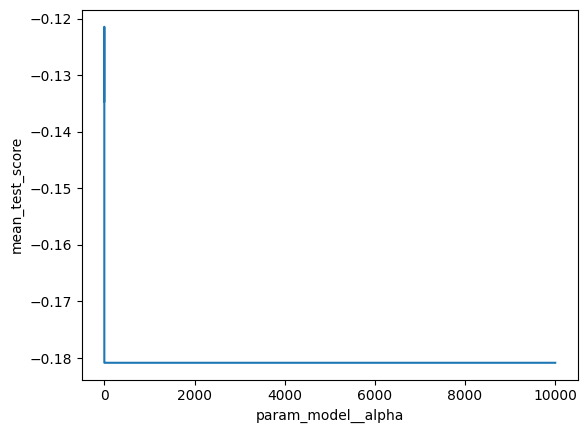

In [14]:
# Visualize Cross-Validation Performance
lasso_search_df = pd.DataFrame(lasso_search.cv_results_)

sns.lineplot(x = 'param_model__alpha',
             y = 'mean_test_score',
             data = lasso_search_df)

# This plot helps visually identify the “sweet spot” where regularization is optimal.

Best alpha: {'model__alpha': 0.01}
Best R2: 0.29690585670761244


<Axes: xlabel='param_model__alpha', ylabel='mean_test_score'>

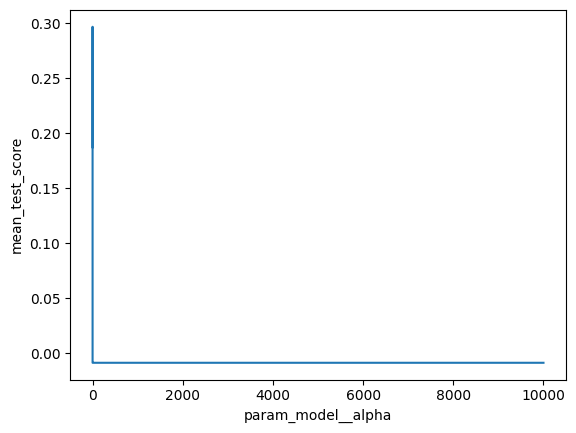

In [15]:
# Run another grid search optimizing for R²
# Trying different scoring metrics (MAE vs R²) 
# can yield different optimal models depending on business goals.

lasso_search2 = GridSearchCV(
    estimator = lasso_pipeline,
    param_grid = param_grid,
    scoring = 'r2', # The different metric
    cv = cv5,
    n_jobs = -1) 

lasso_search2.fit(companies_train_full_X, companies_train_full_y)

print("Best alpha:", lasso_search2.best_params_)
print("Best R2:", lasso_search2.best_score_)

lasso_search2_df = pd.DataFrame(lasso_search2.cv_results_)

sns.lineplot(x = 'param_model__alpha',
             y = 'mean_test_score',
             data = lasso_search2_df)

In [16]:
# Predict with best ElasticNet model (train data)
y_pred_train = lasso_search2.best_estimator_.predict(companies_train_full_X)

# Evaluate performance
print("Train R² score:", r2_score(companies_train_full_y, y_pred_train))
print("Train MAE:", mean_absolute_error(companies_train_full_y, y_pred_train))

Train R² score: 0.42246244861032256
Train MAE: 0.11415798608121526


In [17]:
# Evaluate on Test Set
# Prepare test features and target
companies_test_full_X = companies_test_encoded.drop(columns=['revenuegrowth_t+1'])
companies_test_full_y = companies_test_encoded['revenuegrowth_t+1']

In [18]:
# Predict with best ElasticNet model (test data)
y_pred_test = lasso_search2.best_estimator_.predict(companies_test_full_X)

# Evaluate performance
print("Test R² score:", r2_score(companies_test_full_y, y_pred_test))
print("Test MAE:", mean_absolute_error(companies_test_full_y, y_pred_test))

Test R² score: 0.6056752447411184
Test MAE: 0.09797289484379988


**Analyze LASSO Coefficients**

In [19]:
# LASSO selects a sparse set of the most informative predictors. Great for feature interpretation!
# Extract best model from pipeline
companies_lasso_best = lasso_search2.best_estimator_

model_ = companies_lasso_best['model']

coef_array = model_.coef_

# Map coefficients to predictor names
# (coefficients are in the same order, as variables in  X_train matrix)
predictor_names = companies_train_full_X.columns

#  DataFrame of all the predictors + their coefficients
lasso_coef_df = pd.DataFrame({
    'predictor': predictor_names,
    'coefficient': coef_array
})

lasso_coef_df.head()

# we can observe that some coefficients are equal 0!

,predictor,coefficient
0,revenue,-0.0
1,netincome,-0.0
2,r&d,-0.0
3,sg&a,-0.0
4,ebit,-0.0


In [20]:
# Add absolute value for ranking
lasso_coef_df['abs_coef'] = lasso_coef_df['coefficient'].abs()
# and sort df using this column (descending)
lasso_coef_df.sort_values(by='abs_coef', ascending = False, inplace = True)

# View top predictors
# (having theb highest standardized coefficient values)
lasso_coef_df.head(10)

,predictor,coefficient,abs_coef
5,revenuegrowth,0.118022,0.118022
9,sga_to_revenue,0.060322,0.060322
34,UMCSENT,0.026328,0.026328
6,ebitmargin,-0.025904,0.025904
41,label_Mega‑Cap Tech,0.018913,0.018913
21,roa,0.018411,0.018411
29,GDPC1,-0.015791,0.015791
28,fcf_to_netincome,0.011008,0.011008
35,negative_equity_flag,0.010215,0.010215
8,rd_to_revenue,0.006288,0.006288


In [21]:
# Count how many features were retained vs. zeroed out
# This shows how much feature reduction LASSO achieved. 
# Useful for simplifying models and avoiding overfitting.
(lasso_coef_df.coefficient != 0).value_counts()


coefficient
False    32
True     11
Name: count, dtype: int64

In [22]:
# ElasticNet: Combine Ridge and LASSO
# ElasticNet is often preferred when:
# there are many correlated features in our dataset;
# LASSO selects too few or too many variables

# Define narrower alpha range and l1_ratio (0 = Ridge, 1 = LASSO, between = elasticnet)
alphas = np.logspace(-1, 4, 20)

l1_ratios = np.linspace(0, 1, 6)  # that is 0, 0.2, ..., 1.0

# ElasticNet pipeline
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),   
    ('model', ElasticNet())         
])

param_grid = {
    'model__alpha': alphas,
    'model__l1_ratio': l1_ratios}

# Grid search
elastic_search = GridSearchCV(
    estimator = elastic_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv5,  
    n_jobs = -1)

elastic_search.fit(companies_train_full_X, companies_train_full_y)

print("Best alpha:", elastic_search.best_params_['model__alpha'])
print("Best l1_ratio:", elastic_search.best_params_['model__l1_ratio'])
print("Best (negative) MAE:", elastic_search.best_score_)


Best alpha: 0.1
Best l1_ratio: 0.2
Best (negative) MAE: -0.12239065087537568


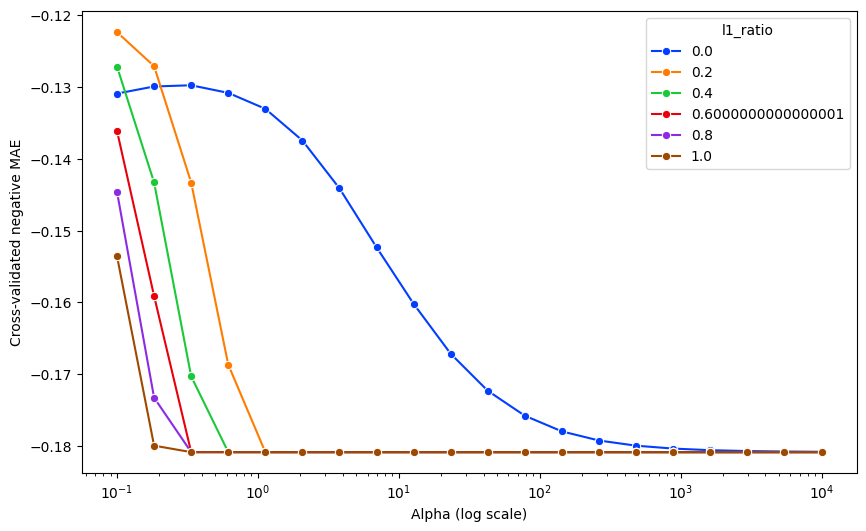

In [23]:
# ElasticNet Performance Visualization
# This helps explore the interaction between regularization strength and mixing penalty (L1 vs L2).

elastic_search_df = pd.DataFrame(elastic_search.cv_results_)

plt.figure(figsize=(10,6))
# plot mean_test_score vs. alfa, and grouping according to l1_ratio
sns.lineplot(
    x = 'param_model__alpha',
    y = 'mean_test_score',
    hue = 'param_model__l1_ratio',
    data = elastic_search_df,
    palette = 'bright',
    marker = 'o'
)

# if alfa is in log scale, it is better to use it on the plt
plt.xscale('log') 
plt.xlabel("Alpha (log scale)")
plt.ylabel("Cross-validated negative MAE")
plt.legend(title="l1_ratio")
plt.show()

In [24]:
elastic_search_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032740,0.001547,0.005218,0.001285,0.1,0.0,"{'model__alpha': 0.1, 'model__l1_ratio': 0.0}",-0.115732,-0.121875,-0.144060,-0.142400,-0.130643,-0.130942,0.011109,7
1,0.010393,0.000526,0.005497,0.000806,0.1,0.2,"{'model__alpha': 0.1, 'model__l1_ratio': 0.2}",-0.109361,-0.117856,-0.119796,-0.136337,-0.128604,-0.122391,0.009275,1
2,0.008809,0.002843,0.005326,0.000458,0.1,0.4,"{'model__alpha': 0.1, 'model__l1_ratio': 0.4}",-0.108896,-0.120743,-0.126683,-0.144791,-0.134824,-0.127187,0.012203,3
3,0.010247,0.000833,0.005473,0.000799,0.1,0.6,"{'model__alpha': 0.1, 'model__l1_ratio': 0.600...",-0.115550,-0.127595,-0.137993,-0.155589,-0.143988,-0.136143,0.013713,9
4,0.010390,0.001012,0.004856,0.001559,0.1,0.8,"{'model__alpha': 0.1, 'model__l1_ratio': 0.8}",-0.121437,-0.135370,-0.149169,-0.163480,-0.153618,-0.144615,0.014699,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.010777,0.000995,0.006138,0.000667,10000.0,0.2,"{'model__alpha': 10000.0, 'model__l1_ratio': 0.2}",-0.165159,-0.167409,-0.186257,-0.196279,-0.189112,-0.180843,0.012349,34
116,0.011112,0.001147,0.004988,0.001069,10000.0,0.4,"{'model__alpha': 10000.0, 'model__l1_ratio': 0.4}",-0.165159,-0.167409,-0.186257,-0.196279,-0.189112,-0.180843,0.012349,34
117,0.011196,0.001227,0.005676,0.000894,10000.0,0.6,"{'model__alpha': 10000.0, 'model__l1_ratio': 0...",-0.165159,-0.167409,-0.186257,-0.196279,-0.189112,-0.180843,0.012349,34
118,0.010346,0.000630,0.004850,0.000878,10000.0,0.8,"{'model__alpha': 10000.0, 'model__l1_ratio': 0.8}",-0.165159,-0.167409,-0.186257,-0.196279,-0.189112,-0.180843,0.012349,34


In [25]:
# Predict with best ElasticNet model (train data)
y_pred_train = elastic_search.best_estimator_.predict(companies_train_full_X)

# Evaluate performance
print("Train R² score:", r2_score(companies_train_full_y, y_pred_train))
print("Train MAE:", mean_absolute_error(companies_train_full_y, y_pred_train))

Train R² score: 0.38726582471941307
Train MAE: 0.11853462996791


In [26]:
# Evaluate on Test Set
# Prepare test features and target
companies_test_full_X = companies_test_encoded.drop(columns=['revenuegrowth_t+1'])
companies_test_full_y = companies_test_encoded['revenuegrowth_t+1']

In [27]:
# Predict with best ElasticNet model (test data)
y_pred_test = elastic_search.best_estimator_.predict(companies_test_full_X)

# Evaluate performance
print("Test R² score:", r2_score(companies_test_full_y, y_pred_test))
print("Test MAE:", mean_absolute_error(companies_test_full_y, y_pred_test))


Test R² score: 0.6009096640438774
Test MAE: 0.09538006690366659


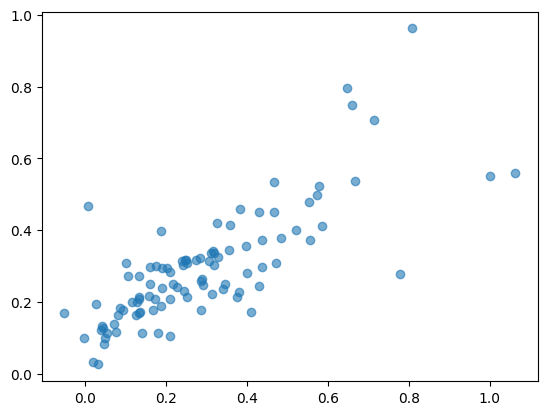

In [28]:
plt.scatter(companies_test_full_y, y_pred_test, alpha=0.6)

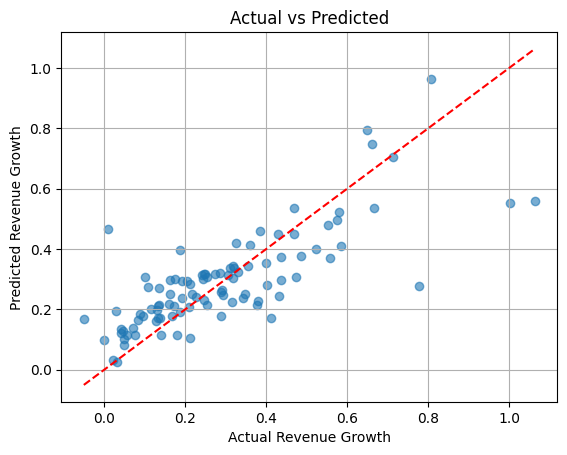

In [29]:
plt.scatter(companies_test_full_y, y_pred_test, alpha=0.6)
plt.xlabel("Actual Revenue Growth")
plt.ylabel("Predicted Revenue Growth")
plt.title("Actual vs Predicted")
plt.plot([companies_test_full_y.min(), companies_test_full_y.max()], [companies_test_full_y.min(), companies_test_full_y.max()], '--r')
plt.grid()
plt.show()

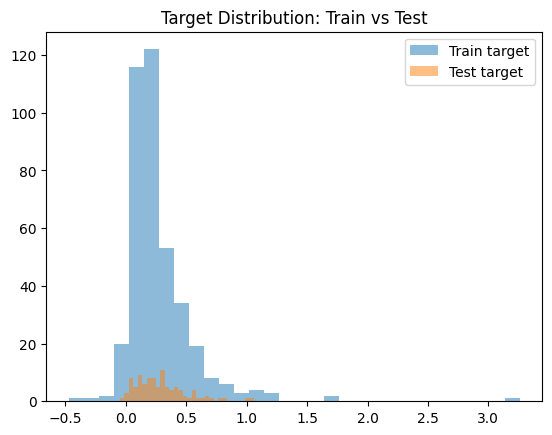

In [30]:
# Check Target Distribution Shift

plt.hist(companies_train_full_y, bins=30, alpha=0.5, label='Train target')
plt.hist(companies_test_full_y, bins=30, alpha=0.5, label='Test target')
plt.legend()
plt.title("Target Distribution: Train vs Test")
plt.show()

Diagnosis: Train/test target distribution mismatch
1. Overall shape
- Both train (blue) and test (orange) targets appear positively skewed (long tail to the right).
- Most values are clustered between 0 and 0.5, with a sharp peak close to 0.1–0.2.
- There are some outliers on the right side (values > 1.5), especially in the train set.
2. Train vs. test distribution
- The train target distribution dominates the plot (higher count, larger sample size).
- The test target distribution is smaller but generally overlaps the main peak of the train distribution.
- However, the test set might be slightly narrower (less extreme values in the right tail).
- No obvious major shift, but there could be a slight distribution mismatch:
  - Train set has rare high-value outliers (up to ~3.3).
  - Test set seems capped closer to ~1.0.
3. Possible concerns
- Distribution shift risk: If the test set has fewer extreme values than the train set, models might perform differently in real-world predictions where such extremes occur.
- Target skewness: A skewed distribution like this often benefits from transformation (e.g., log or Box–Cox) to stabilize variance and improve model performance, especially for linear models.
- Imbalanced scale: The large spike near zero suggests many low values; models may bias toward predicting close to the peak if not handled carefully.

Summary: Step-by-step recommendation

1. Plot target distributions (train vs test: got insight); 
2. Try Random Forest: helped :) 
3. Consider log-transforming the target: helped only a little;
4. Engineer new feat: did not helped;
5. Use multiple companies to train: I did it.